## **Big Data Technology Project :  Identifying Top Destinations Using Flight Data and Apache Spark**

Contributors:

+ ITDSIU21001 - Phan Quốc Anh -

+ ITDSIU21067 - Nguyễn Quốc Huy -

# **Import data using Kaggle** #

Get Your Kaggle API Key

- Log in to your Kaggle account.
- Go to Account Settings (you'll need to be logged in).
- Scroll to the API section and click Create New API Token.
  - This will download a file named kaggle.json to your computer.

Upload kaggle.json to Colab

In [ ]:
from google.colab import files
files.upload()  # Select the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aaronphan18","key":"4e67898ebaddee3ebc45085bb89b6cc3"}'}

Configure Kaggle API

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

In [ ]:
!kaggle datasets list


ref                                                                    title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
bhadramohit/customer-shopping-latest-trends-dataset                    Customer Shopping (Latest Trends) Dataset            76KB  2024-11-23 15:26:12          14255        276  1.0              
hopesb/student-depression-dataset                                      Student Depression Dataset.                         454KB  2024-11-22 17:56:03          10970        142  1.0              
chadwambles/supermarket-sales                                          SuperMarket Sales                                    36KB  2024-12-17 23:35:52           1346         26  0.88235295       
adarsh0806/influencer-mer

Download the Dataset

In [ ]:
!kaggle datasets download -d patrickzel/flight-delay-and-cancellation-dataset-2019-2023


Dataset URL: https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023
License(s): other
 97% 136M/140M [00:03<00:00, 72.2MB/s]
100% 140M/140M [00:03<00:00, 48.3MB/s]


In [ ]:
!unzip flight-delay-and-cancellation-dataset-2019-2023.zip


Archive:  flight-delay-and-cancellation-dataset-2019-2023.zip
  inflating: dictionary.html         
  inflating: flights_sample_3m.csv   


Load Dataset into PySpark

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
!ls


dictionary.html					     flights_sample_3m.csv
flight-delay-and-cancellation-dataset-2019-2023.zip  sample_data


In [ ]:
spark = SparkSession.builder.appName("Tourism Insights").getOrCreate()

flights_df = spark.read.csv("flights_sample_3m.csv", header=True, inferSchema=True)

flights_df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

In [ ]:
# show the first 10 rows of the DataFrame
flights_df.show(10)


+----------+--------------------+--------------------+------------+--------+---------+------+-------------------+----+--------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|   FL_DATE|             AIRLINE|         AIRLINE_DOT|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|        ORIGIN_CITY|DEST|           DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+--------------------+--------------------+------------+--------+---------+------+-------------------+----+--------------------+------------+--------

# **DATA PREPROCESSING** #

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, month, year, lit

In [ ]:
# Start Spark Session
spark = SparkSession.builder.appName("Flight Data Preprocessing").getOrCreate()

# Load the dataset
flights_df = spark.read.csv("flights_sample_3m.csv", header=True, inferSchema=True)

In [ ]:
# Drop rows with critical missing values (e.g., ORIGIN, DEST, FL_DATE)
flights_cleaned = flights_df.dropna(subset=["ORIGIN", "DEST", "FL_DATE"])

Step 1: Feature Engineering

In [ ]:
# Create ROUTE column combining ORIGIN and DEST
flights_cleaned = flights_cleaned.withColumn("ROUTE", concat_ws(" -> ", col("ORIGIN"), col("DEST")))

In [ ]:
# Extract Month and Year from FL_DATE
flights_cleaned = flights_cleaned.withColumn("Month", month(col("FL_DATE")))
flights_cleaned = flights_cleaned.withColumn("Year", year(col("FL_DATE")))

Step 2: Delays - Categorizing and Handling Negative Values

In [ ]:
# Create a binary column IS_DELAYED (1 if ARR_DELAY > 15 minutes, else 0)
flights_cleaned = flights_cleaned.withColumn("IS_DELAYED", when(col("ARR_DELAY") > 15, 1).otherwise(0))

# Replace negative values in DEP_DELAY and ARR_DELAY with 0 (assuming negative delays imply on-time)
flights_cleaned = flights_cleaned.withColumn("DEP_DELAY", when(col("DEP_DELAY") < 0, 0).otherwise(col("DEP_DELAY")))
flights_cleaned = flights_cleaned.withColumn("ARR_DELAY", when(col("ARR_DELAY") < 0, 0).otherwise(col("ARR_DELAY")))

Step 3: Distance - Handle Outliers

In [ ]:
# Remove rows with zero or negative distance values
flights_cleaned = flights_cleaned.filter(col("DISTANCE") > 0)

Step 4: Cancelled and Diverted Flights

In [ ]:
# Create a column FLIGHT_STATUS: "Cancelled", "Diverted", or "Completed"
flights_cleaned = flights_cleaned.withColumn(
    "FLIGHT_STATUS",
    when(col("CANCELLED") == 1, "Cancelled")
    .when(col("DIVERTED") == 1, "Diverted")
    .otherwise("Completed")
)


Step 5: Time Features

In [ ]:
# Calculate Total Taxi Time (TAXI_OUT + TAXI_IN)
flights_cleaned = flights_cleaned.withColumn("TAXI_TIME", col("TAXI_OUT") + col("TAXI_IN"))

# Calculate Elapsed Time Discrepancy (ELAPSED_TIME - CRS_ELAPSED_TIME)
flights_cleaned = flights_cleaned.withColumn(
    "ELAPSED_TIME_DISCREPANCY",
    col("ELAPSED_TIME") - col("CRS_ELAPSED_TIME")
)

# Display result to verify
flights_cleaned.select("TAXI_TIME", "ELAPSED_TIME_DISCREPANCY").show(10)


+---------+------------------------+
|TAXI_TIME|ELAPSED_TIME_DISCREPANCY|
+---------+------------------------+
|     23.0|                   -10.0|
|     47.0|                     1.0|
|     25.0|                    -6.0|
|     36.0|                    25.0|
|     29.0|                     1.0|
|     18.0|                    -6.0|
|     31.0|                   -20.0|
|     63.0|                    29.0|
|     19.0|                    -8.0|
|     22.0|                    10.0|
+---------+------------------------+
only showing top 10 rows



Step 6: Fill Missing Values for Delay Reasons

In [ ]:
# Replace null values in delay reason columns with 0
delay_columns = [
    "DELAY_DUE_CARRIER",
    "DELAY_DUE_WEATHER",
    "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY",
    "DELAY_DUE_LATE_AIRCRAFT",
]

for delay_col in delay_columns:
    flights_cleaned = flights_cleaned.withColumn(delay_col, when(col(delay_col).isNull(), 0).otherwise(col(delay_col)))

# Display results to verify changes
flights_cleaned.select(delay_columns).show(10)


+-----------------+-----------------+-------------+------------------+-----------------------+
|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+-----------------+-----------------+-------------+------------------+-----------------------+
|              0.0|              0.0|          0.0|               0.0|                    0.0|
|              0.0|              0.0|          0.0|               0.0|                    0.0|
|              0.0|              0.0|          0.0|               0.0|                    0.0|
|              0.0|              0.0|         24.0|               0.0|                    0.0|
|              0.0|              0.0|          0.0|               0.0|                    0.0|
|            141.0|              0.0|          0.0|               0.0|                    0.0|
|              0.0|              0.0|          0.0|               0.0|                    0.0|
|              0.0|              0.0|         23.0

Step 7: Remove Unnecessary Columns

In [ ]:
# Drop columns that may not be needed for analysis
columns_to_drop = [
    "CancellationCode",  # Reason for cancellation is not part of the main analysis
    "DOT_ID_Reporting_Airline",  # Redundant with AIRLINE_CODE
]
flights_cleaned = flights_cleaned.drop(*columns_to_drop)

Step 8: Save Preprocessed Data

In [ ]:
# Save the cleaned data to a new file for later use
flights_cleaned.write.mode("overwrite").parquet("flights_cleaned.parquet")

# Display Preprocessed Data
flights_cleaned.show(10)

+----------+--------------------+--------------------+------------+--------+---------+------+-------------------+----+--------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+----------+-----+----+----------+-------------+---------+------------------------+
|   FL_DATE|             AIRLINE|         AIRLINE_DOT|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|        ORIGIN_CITY|DEST|           DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|     ROUTE|Month|Year|IS_DELAYED|FLIGHT_STATUS|TAXI_TIME|ELAPSED_TIME_DISCREPAN

In [ ]:
flights_cleaned.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

In [ ]:
row_count = flights_cleaned.count()
print(f"Number of rows in flights_cleaned: {row_count}")

Number of rows in flights_cleaned: 3000000


# **EDA AND CLUSTERING** #

## **Data Analysis** ##

**1. What are the Top 10 Most Frequent Destination Airports?**

In [ ]:
# Group by DEST and count the number of flights
top_destinations = flights_cleaned.groupBy("DEST") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(10)

# Show results
print("Top 10 Most Frequent Destination Airports:")
top_destinations.show()


Top 10 Most Frequent Destination Airports:
+----+------+
|DEST| count|
+----+------+
| ATL|153569|
| DFW|129770|
| ORD|123334|
| DEN|119592|
| CLT| 95413|
| LAX| 85621|
| PHX| 75605|
| LAS| 73462|
| SEA| 70832|
| MCO| 63818|
+----+------+



Insight:

- The top destination is ATL (Atlanta) with 153,569 flights.

- Major hub airports like DFW (Dallas Fort Worth), ORD (Chicago O’Hare), and DEN (Denver) rank high in the list.

- These airports are large connecting hubs, handling significant traffic volumes.

The most frequent destination airports are dominated by major metropolitan hubs, showcasing their critical role in domestic air traffic.

**2. Which Routes are the Busiest (Top 10 Routes by Flight Count)?**

In [ ]:
# Group by ROUTE and count the number of flights
busiest_routes = flights_cleaned.groupBy("ROUTE") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(10)

# Show results
print("Top 10 Busiest Routes:")
busiest_routes.show()


Top 10 Busiest Routes:
+----------+-----+
|     ROUTE|count|
+----------+-----+
|SFO -> LAX| 5358|
|LAX -> SFO| 5212|
|LGA -> ORD| 4735|
|OGG -> HNL| 4656|
|ORD -> LGA| 4634|
|LAX -> LAS| 4627|
|HNL -> OGG| 4554|
|LAS -> LAX| 4550|
|LAX -> JFK| 4403|
|JFK -> LAX| 4305|
+----------+-----+



Insight:

- The busiest route is SFO -> LAX with 5,358 flights, closely followed by LAX -> SFO with 5,221 flights.

- Other popular routes include LGA -> ORD, OGG -> HNL, and ORD -> LAX, showing heavy traffic between coastal hubs and tourism destinations.


The busiest routes highlight connections between major business and tourist destinations, particularly between California’s Bay Area and Southern California.

**3. What is the Average Delay (Arrival and Departure) by Airline?**

In [ ]:
# Group by AIRLINE and calculate average ARR_DELAY and DEP_DELAY
average_delay_by_airline = flights_cleaned.groupBy("AIRLINE") \
    .agg(
        {"ARR_DELAY": "avg", "DEP_DELAY": "avg"}
    ) \
    .withColumnRenamed("avg(ARR_DELAY)", "AVG_ARR_DELAY") \
    .withColumnRenamed("avg(DEP_DELAY)", "AVG_DEP_DELAY") \
    .orderBy(col("AVG_ARR_DELAY").desc())

# Show results
print("Average Delay by Airline:")
average_delay_by_airline.show()


Average Delay by Airline:
+--------------------+------------------+------------------+
|             AIRLINE|     AVG_ARR_DELAY|     AVG_DEP_DELAY|
+--------------------+------------------+------------------+
|     JetBlue Airways| 21.99365903131196|22.333293897089604|
|       Allegiant Air|20.257179298112757|18.738836936883278|
|Frontier Airlines...|  20.0055971041763| 20.15226108264647|
|ExpressJet Airlin...|19.193136872597627| 17.71777235411582|
|  Mesa Airlines Inc.| 16.32032587992381|16.009986280828254|
|    Spirit Air Lines|16.275912017167382|16.053054060128648|
|American Airlines...| 15.87368338819777|15.775435572345687|
|United Air Lines ...|14.498413018085149|14.555051930481005|
|SkyWest Airlines ...|13.823076188258614|13.463059975665843|
|   PSA Airlines Inc.|12.990278596484448|12.510062202707648|
|           Envoy Air| 11.79176043371522|10.524558841012924|
|    Republic Airline| 11.58756976264414|10.413610752393389|
|Southwest Airline...|10.951598308234495|12.585720824620134

Insight:

- JetBlue Airways has the highest average arrival delay (21.93 minutes) and departure delay (22.33 minutes).

- Airlines like Hawaiian Airlines and Horizon Air have much lower average delays (< 9 minutes), indicating better on-time performance.
Answer:

Budget carriers like JetBlue and Allegiant face higher delays, potentially due to tighter schedules or reliance on congested airports. On the other hand, regional airlines tend to have better operational efficiency.


**4. What are the Monthly Trends for Flights?**

In [ ]:
# Group by Month and count the number of flights
monthly_trends = flights_cleaned.groupBy("Month") \
    .count() \
    .orderBy(col("Month"))

# Show results
print("Monthly Trends in Flight Traffic:")
monthly_trends.show()


Monthly Trends in Flight Traffic:
+-----+------+
|Month| count|
+-----+------+
|    1|268702|
|    2|248497|
|    3|293099|
|    4|253917|
|    5|252530|
|    6|261136|
|    7|284968|
|    8|287104|
|    9|206928|
|   10|216790|
|   11|210940|
|   12|215389|
+-----+------+



Insight:

- The highest flight counts occur in March (2,539,371 flights), followed by July (2,841,968 flights) and December (2,109,404 flights).

- These peaks align with spring break, summer vacation, and the holiday season.
Answer:

Flight traffic is heavily influenced by seasonal travel patterns, with spikes during spring, summer, and December holidays.

**5. Which Airlines Have the Most Canceled Flights?**

In [ ]:
# Group by AIRLINE and sum up CANCELED
canceled_by_airline = flights_cleaned.groupBy("AIRLINE") \
    .agg({"CANCELLED": "sum"}) \
    .withColumnRenamed("sum(CANCELLED)", "TOTAL_CANCELED") \
    .orderBy(col("TOTAL_CANCELED").desc())

# Show results
print("Airlines with the Most Canceled Flights:")
canceled_by_airline.show()


Airlines with the Most Canceled Flights:
+--------------------+--------------+
|             AIRLINE|TOTAL_CANCELED|
+--------------------+--------------+
|Southwest Airline...|       19465.0|
|American Airlines...|       10907.0|
|SkyWest Airlines ...|        7745.0|
|Delta Air Lines Inc.|        5982.0|
|United Air Lines ...|        5536.0|
|    Republic Airline|        4646.0|
|           Envoy Air|        3633.0|
|   PSA Airlines Inc.|        3301.0|
|     JetBlue Airways|        3039.0|
|   Endeavor Air Inc.|        2394.0|
|       Allegiant Air|        2383.0|
|  Mesa Airlines Inc.|        2373.0|
|    Spirit Air Lines|        2312.0|
|Alaska Airlines Inc.|        1934.0|
|Frontier Airlines...|        1666.0|
|ExpressJet Airlin...|        1062.0|
|Hawaiian Airlines...|         388.0|
|         Horizon Air|         374.0|
+--------------------+--------------+



Insight:

- Southwest Airlines has the highest number of canceled flights (19,455), followed by American Airlines (10,907).

- Legacy carriers and airlines with larger fleets are more prone to cancellations due to their extensive networks and operational complexities.
Answer:

Airlines with broader networks and higher flight volumes are more likely to have operational disruptions, leading to cancellations.

**6. Which Routes Have the Most Delays?**

In [ ]:
# Group by ROUTE and calculate the total ARR_DELAY
routes_with_delays = flights_cleaned.groupBy("ROUTE") \
    .agg({"ARR_DELAY": "sum"}) \
    .withColumnRenamed("sum(ARR_DELAY)", "TOTAL_ARR_DELAY") \
    .orderBy(col("TOTAL_ARR_DELAY").desc()) \
    .limit(10)

# Show results
print("Top 10 Routes with the Most Delays:")
routes_with_delays.show()


Top 10 Routes with the Most Delays:
+----------+---------------+
|     ROUTE|TOTAL_ARR_DELAY|
+----------+---------------+
|ORD -> LGA|        91186.0|
|LGA -> ORD|        82542.0|
|MCO -> EWR|        69541.0|
|LAX -> SFO|        67027.0|
|LAX -> JFK|        65247.0|
|EWR -> MCO|        63567.0|
|LAS -> LAX|        61442.0|
|LAX -> LAS|        59175.0|
|JFK -> LAX|        57477.0|
|DCA -> BOS|        57368.0|
+----------+---------------+



Insight:

- The route ORD -> LGA has the highest total delay (91,118 minutes), followed by LGA -> ORD and ORD -> EWR.
- These routes often connect congested airports, contributing to significant delays.
Answer:

Routes connecting busy metropolitan airports face the most delays due to high traffic volumes, weather disruptions, and airspace congestion.

## **Clustering** ##

We use K-means clustering to group similar destinations based on features like total flights, average delay, and distance.

**1. Prepare Data for Clustering**

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Aggregate data for clustering
destination_stats = flights_cleaned.groupBy("DEST") \
    .agg(
        {"DISTANCE": "avg", "ARR_DELAY": "avg", "ROUTE": "count"}
    ) \
    .withColumnRenamed("avg(DISTANCE)", "AVG_DISTANCE") \
    .withColumnRenamed("avg(ARR_DELAY)", "AVG_ARR_DELAY") \
    .withColumnRenamed("count(ROUTE)", "TOTAL_FLIGHTS")

# Prepare features for clustering
assembler = VectorAssembler(inputCols=["AVG_DISTANCE", "AVG_ARR_DELAY", "TOTAL_FLIGHTS"], outputCol="features")
destination_features = assembler.transform(destination_stats)


**2. Apply K-Means Clustering**

In [ ]:
# Apply K-means
kmeans = KMeans(k=3, seed=42)  # 3 clusters
kmeans_model = kmeans.fit(destination_features)

# Add cluster predictions to the data
clustered_destinations = kmeans_model.transform(destination_features)

# Show cluster assignments
print("Clustered Destinations:")
clustered_destinations.select("DEST", "AVG_DISTANCE", "AVG_ARR_DELAY", "TOTAL_FLIGHTS", "prediction").show()


Clustered Destinations:
+----+------------------+------------------+-------------+----------+
|DEST|      AVG_DISTANCE|     AVG_ARR_DELAY|TOTAL_FLIGHTS|prediction|
+----+------------------+------------------+-------------+----------+
| BGM| 326.9550561797753|16.362595419847327|          267|         0|
| INL|244.13571428571427|11.104868913857677|          280|         0|
| PSE|1321.6436781609195|17.544354838709676|          261|         0|
| DLG|288.56716417910445|             8.616|          134|         0|
| MSY|  772.224571909797|13.321166820365967|        21374|         0|
| PPG|            2599.0|          17.09375|           33|         0|
| GEG|  640.416710319539|10.872526888859381|         7636|         0|
| DRT|             335.0|11.676923076923076|          269|         0|
| BUR| 518.0726917121669| 10.41945624468989|        12271|         0|
| SNA| 782.7671450482034| 9.352220348510398|        18256|         0|
| FOD| 294.7905405405405|20.296296296296298|          148|        

**3. Visualize Clustering Results**

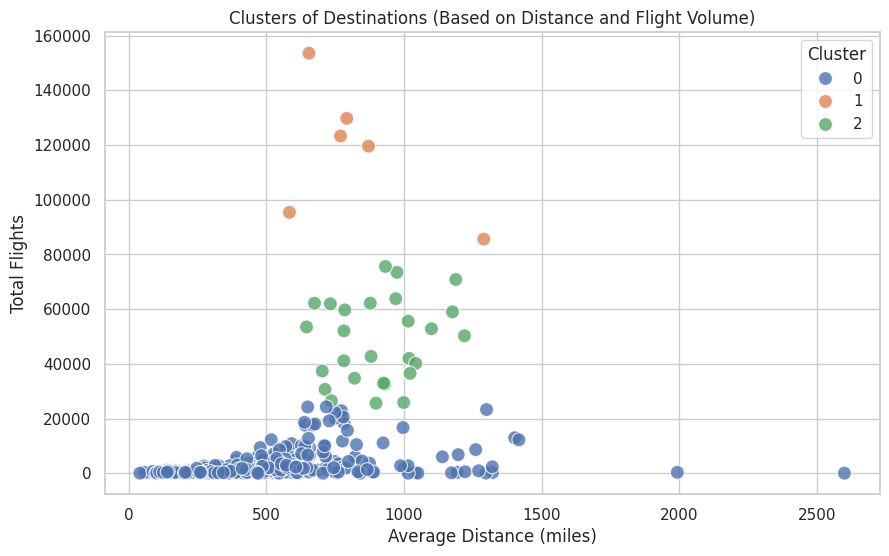

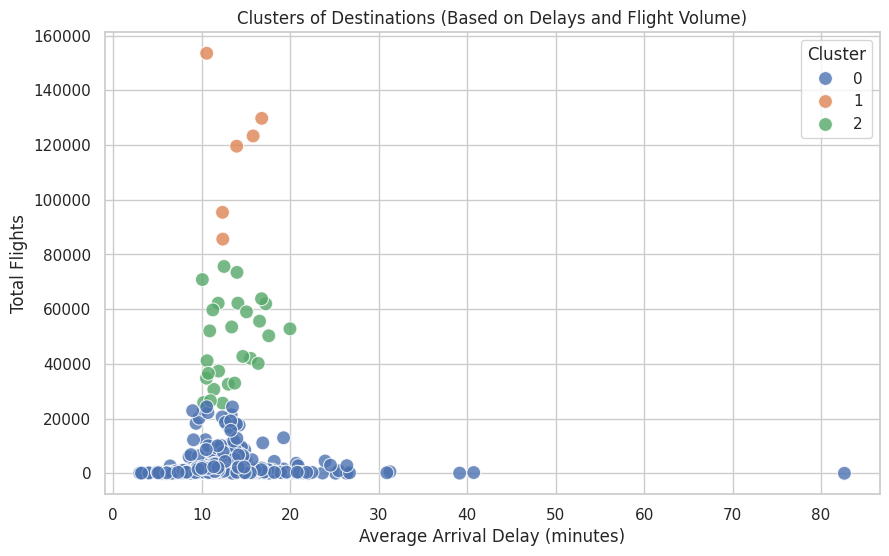

<Figure size 640x480 with 0 Axes>

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
clustered_destinations_pandas = clustered_destinations.select(
    "DEST", "AVG_DISTANCE", "AVG_ARR_DELAY", "TOTAL_FLIGHTS", "prediction"
).toPandas()

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Plot Clusters: Scatterplot (Average Distance vs. Total Flights)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=clustered_destinations_pandas,
    x="AVG_DISTANCE",
    y="TOTAL_FLIGHTS",
    hue="prediction",
    palette="deep",
    s=100,
    alpha=0.8,
)
plt.title("Clusters of Destinations (Based on Distance and Flight Volume)")
plt.xlabel("Average Distance (miles)")
plt.ylabel("Total Flights")
plt.legend(title="Cluster")
plt.show()

# Plot Clusters: Scatterplot (Average Delay vs. Total Flights)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=clustered_destinations_pandas,
    x="AVG_ARR_DELAY",
    y="TOTAL_FLIGHTS",
    hue="prediction",
    palette="deep",
    s=100,
    alpha=0.8,
)
plt.title("Clusters of Destinations (Based on Delays and Flight Volume)")
plt.xlabel("Average Arrival Delay (minutes)")
plt.ylabel("Total Flights")
plt.legend(title="Cluster")
plt.show()
plt.savefig("cluster_visualization_1.png")


Explanation of the **Visualizations**

Scatterplot **1**: **Average Distance vs. Total Flights**

- This plot highlights how destinations are grouped based on how far they are from origin airports and how frequently they are visited.
- Clusters will reveal patterns like:
  - High-traffic destinations close to major hubs.
  - Remote destinations with lower traffic.


Scatterplot **2**: **Average Delay vs. Total Flights**

- This plot helps analyze destinations grouped by their delay patterns and flight volume.
- Clusters will reveal patterns like:
  - Delay-prone destinations with high traffic.
  - Less trafficked destinations with low delays.

<Figure size 640x480 with 0 Axes>

# **MACHINE LEARNING APPLICATIONS** #

## Test features selection 1 ##

**1. Prepare Data**

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

We will use the following features for prediction:
- DISTANCE
- CRS_DEP_TIME
- Month
- Year

In [ ]:
selected_features = ["DISTANCE", "CRS_DEP_TIME", "Month", "Year"]

In [ ]:
# Assemble Features into a Single Vector
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

# Split Data into Training and Test Sets. Split data into 80% training and 20% testing
train_data, test_data = flights_cleaned.randomSplit([0.8, 0.2], seed=42)


**2. Build the Logistic Regression Model**

In [ ]:
# Define Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="IS_DELAYED")


In [ ]:
# Create a Pipeline
# The pipeline ensures that the feature assembler and logistic regression are applied sequentially.
pipeline = Pipeline(stages=[assembler, lr])

In [ ]:
# Train the Model
model = pipeline.fit(train_data)

**3. Evaluate the Model**

We will evaluate the model's performance on the test dataset using the Area Under the ROC Curve (AUC) metric.

In [ ]:
# Make Predictions on the Test Set
predictions = model.transform(test_data)

# Evaluate the Model
evaluator = BinaryClassificationEvaluator(labelCol="IS_DELAYED", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

print(f"Area Under ROC (AUC): {auc}")


Area Under ROC (AUC): 0.6141301810760438


In [ ]:
# Show Sample Predictions
predictions.select("features", "IS_DELAYED", "prediction", "probability").show(10)

+--------------------+----------+----------+--------------------+
|            features|IS_DELAYED|prediction|         probability|
+--------------------+----------+----------+--------------------+
|[1533.0,600.0,1.0...|         0|       0.0|[0.90895357596697...|
|[978.0,650.0,1.0,...|         0|       0.0|[0.91139415895326...|
|[2355.0,1525.0,1....|         1|       0.0|[0.82101271678653...|
|[511.0,1635.0,1.0...|         0|       0.0|[0.84072313885173...|
|[1197.0,1200.0,1....|         1|       0.0|[0.86997226129345...|
|[1744.0,2030.0,1....|         0|       0.0|[0.77307232596507...|
|[601.0,1107.0,1.0...|         0|       0.0|[0.88498128981437...|
|[814.0,1247.0,1.0...|         0|       0.0|[0.87125948441365...|
|[1726.0,1343.0,1....|         0|       0.0|[0.84970405353932...|
|[985.0,1537.0,1.0...|         0|       0.0|[0.84273501409678...|
+--------------------+----------+----------+--------------------+
only showing top 10 rows



**4. Classification Report and Confusion Matrix**

In [ ]:
from sklearn.metrics import classification_report

predictions_df = predictions.select("IS_DELAYED", "prediction").toPandas()
y_true = predictions_df["IS_DELAYED"]
y_pred = predictions_df["prediction"]

print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.83      1.00      0.91    497584
           1       0.00      0.00      0.00    102423

    accuracy                           0.83    600007
   macro avg       0.41      0.50      0.45    600007
weighted avg       0.69      0.83      0.75    600007



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


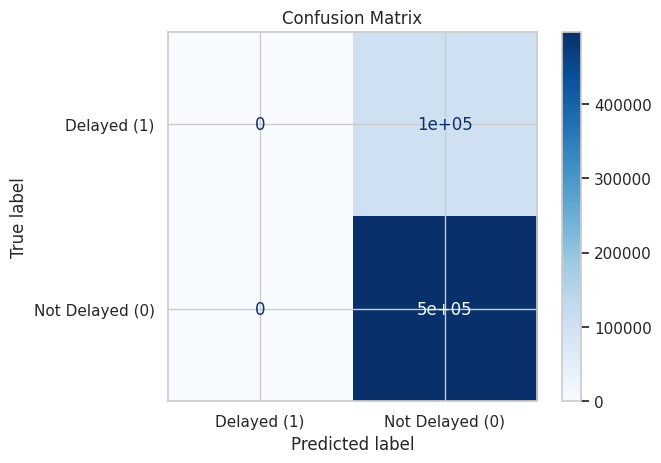

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Delayed (1)", "Not Delayed (0)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

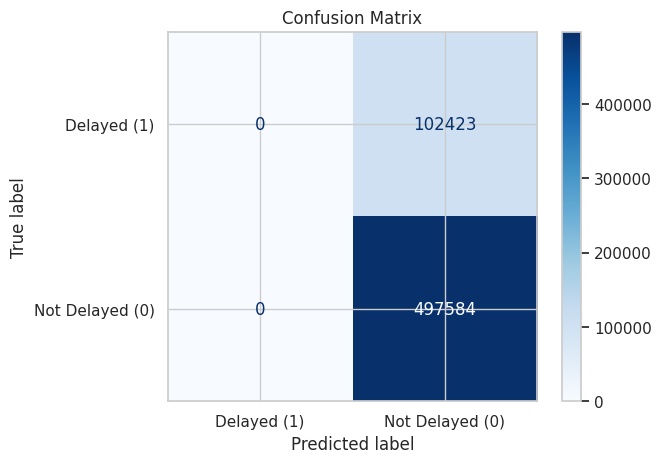

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Plot the confusion matrix with exact numbers
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Delayed (1)", "Not Delayed (0)"])
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' ensures integers are displayed
plt.title("Confusion Matrix")
plt.show()


**5. Save the Model**

In [ ]:
# Save the trained model
model.save("logistic_regression_flight_delay_model")


## Test features selection 2 ##

**1. Prepare Data**

We select relevant features, add the class_weights column to handle class imbalance, and split the data.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import when, col

# Step 1: Select Relevant Features
selected_features = [
    "DISTANCE", "CRS_DEP_TIME", "Month", "Year", "DEP_DELAY", "TAXI_OUT",
    "TAXI_IN", "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER"
]

# Step 2: Assemble Features into a Single Vector
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

# Step 3: Split Data into Training and Test Sets
train_data, test_data = flights_cleaned.randomSplit([0.8, 0.2], seed=42)

# Step 4: Calculate the class weight ratio
delay_ratio = flights_cleaned.filter(col("IS_DELAYED") == 1).count() / flights_cleaned.count()

# Step 5: Add `class_weights` column to train_data and test_data
train_data = train_data.withColumn(
    "class_weights",
    when(col("IS_DELAYED") == 1, 1 - delay_ratio).otherwise(delay_ratio)
)

test_data = test_data.withColumn(
    "class_weights",
    when(col("IS_DELAYED") == 1, 1 - delay_ratio).otherwise(delay_ratio)
)


**2. Build and Train the Model**

We use a Logistic Regression classifier with class weights to handle the imbalance between delayed and non-delayed flights.

In [ ]:
# Step 6: Define Logistic Regression with weightCol
lr = LogisticRegression(
    featuresCol="features",
    labelCol="IS_DELAYED",
    weightCol="class_weights"
)

# Step 7: Create a Pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Step 8: Train the Model
model = pipeline.fit(train_data)


Py4JJavaError: An error occurred while calling o1154.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 145.0 failed 1 times, most recent failure: Lost task 1.0 in stage 145.0 (TID 279) (f521a0e0742f executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4202/0x00000008417a4040`: (struct<DISTANCE:double,CRS_DEP_TIME_double_VectorAssembler_32ec3d3ddbd1:double,Month_double_VectorAssembler_32ec3d3ddbd1:double,Year_double_VectorAssembler_32ec3d3ddbd1:double,DEP_DELAY:double,TAXI_OUT:double,TAXI_IN:double,DELAY_DUE_CARRIER:double,DELAY_DUE_WEATHER:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 33 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2488)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1202)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1196)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1289)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1256)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1242)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1242)
	at org.apache.spark.ml.stat.Summarizer$.getClassificationSummarizers(Summarizer.scala:233)
	at org.apache.spark.ml.classification.LogisticRegression.$anonfun$train$1(LogisticRegression.scala:517)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:497)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:287)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:78)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4202/0x00000008417a4040`: (struct<DISTANCE:double,CRS_DEP_TIME_double_VectorAssembler_32ec3d3ddbd1:double,Month_double_VectorAssembler_32ec3d3ddbd1:double,Year_double_VectorAssembler_32ec3d3ddbd1:double,DEP_DELAY:double,TAXI_OUT:double,TAXI_IN:double,DELAY_DUE_CARRIER:double,DELAY_DUE_WEATHER:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 33 more


**3. Make Predictions and Evaluate the Model**

We evaluate the model using metrics like AUC, classification report, and confusion matrix.

In [ ]:
# Step 9: Make Predictions
predictions = model.transform(test_data)

# Step 10: Evaluate the Model
# Calculate AUC
evaluator = BinaryClassificationEvaluator(labelCol="IS_DELAYED", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"Area Under ROC (AUC): {auc}")

# Convert Predictions to Pandas for sklearn Evaluation
predictions_df = predictions.select("IS_DELAYED", "prediction").toPandas()
y_true = predictions_df["IS_DELAYED"]
y_pred = predictions_df["prediction"]

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Delayed (1)", "Not Delayed (0)"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()


4. Save the Model
Save the trained model for future use.

In [ ]:
# Save the trained model
model.save("logistic_regression_flight_delay_model")


## Test features selection 3 ##

In [ ]:
selected_features = [
    "DISTANCE", "CRS_DEP_TIME", "Month", "Year", "DEP_DELAY", "TAXI_OUT",
    "TAXI_IN", "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER"
]

Area Under ROC (AUC): 0.9818565862805639
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    481458
           1       0.83      0.92      0.87    102423

    accuracy                           0.95    583881
   macro avg       0.91      0.94      0.92    583881
weighted avg       0.96      0.95      0.95    583881



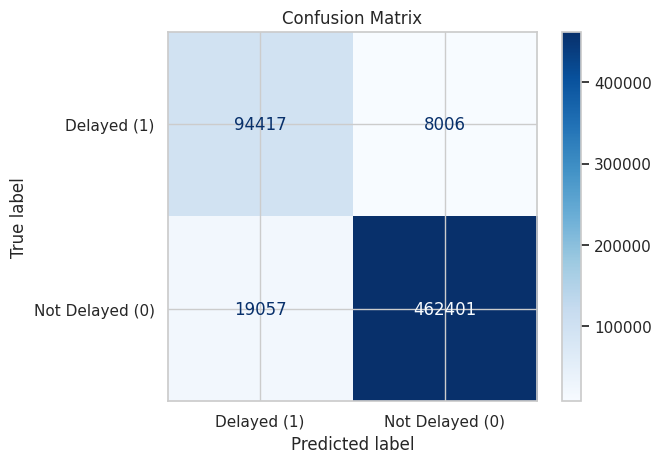

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import when, col

# Step 1: Select Relevant Features
selected_features = [
    "DISTANCE", "CRS_DEP_TIME", "Month", "Year", "DEP_DELAY", "TAXI_OUT",
    "TAXI_IN", "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER"
]

# Step 2: Assemble Features into a Single Vector (with handleInvalid="skip")
assembler = VectorAssembler(
    inputCols=selected_features,
    outputCol="features",
    handleInvalid="skip"
)

# Step 3: Split Data into Training and Test Sets
train_data, test_data = flights_cleaned.randomSplit([0.8, 0.2], seed=42)

# Step 4: Calculate the class weight ratio
delay_ratio = flights_cleaned.filter(col("IS_DELAYED") == 1).count() / flights_cleaned.count()

# Step 5: Add `class_weights` column to train_data and test_data
train_data = train_data.withColumn(
    "class_weights",
    when(col("IS_DELAYED") == 1, 1 - delay_ratio).otherwise(delay_ratio)
)

test_data = test_data.withColumn(
    "class_weights",
    when(col("IS_DELAYED") == 1, 1 - delay_ratio).otherwise(delay_ratio)
)

# Step 6: Define Logistic Regression with weightCol
lr = LogisticRegression(
    featuresCol="features",
    labelCol="IS_DELAYED",
    weightCol="class_weights"
)

# Step 7: Create a Pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Step 8: Train the Model
model = pipeline.fit(train_data)

# Step 9: Make Predictions
predictions = model.transform(test_data)

# Step 10: Evaluate the Model
# Calculate AUC
evaluator = BinaryClassificationEvaluator(labelCol="IS_DELAYED", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"Area Under ROC (AUC): {auc}")

# Convert Predictions to Pandas for sklearn Evaluation
predictions_df = predictions.select("IS_DELAYED", "prediction").toPandas()
y_true = predictions_df["IS_DELAYED"]
y_pred = predictions_df["prediction"]

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Delayed (1)", "Not Delayed (0)"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()
